In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv')
df.head(3)

,Laptop,Status,Brand,Model,CPU,RAM,Storage,Storage type,GPU,Screen,Touch,Final Price
0,ASUS ExpertBook B1 B1502CBA-EJ0436X Intel Core...,New,Asus,ExpertBook,Intel Core i5,8,512,SSD,NaN,15.6,No,1009.0
1,Alurin Go Start Intel Celeron N4020/8GB/256GB ...,New,Alurin,Go,Intel Celeron,8,256,SSD,NaN,15.6,No,299.0
2,ASUS ExpertBook B1 B1502CBA-EJ0424X Intel Core...,New,Asus,ExpertBook,Intel Core i3,8,256,SSD,NaN,15.6,No,789.0


In [3]:
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.head(3)

,laptop,status,brand,model,cpu,ram,storage,storage_type,gpu,screen,touch,final_price
0,ASUS ExpertBook B1 B1502CBA-EJ0436X Intel Core...,New,Asus,ExpertBook,Intel Core i5,8,512,SSD,NaN,15.6,No,1009.0
1,Alurin Go Start Intel Celeron N4020/8GB/256GB ...,New,Alurin,Go,Intel Celeron,8,256,SSD,NaN,15.6,No,299.0
2,ASUS ExpertBook B1 B1502CBA-EJ0424X Intel Core...,New,Asus,ExpertBook,Intel Core i3,8,256,SSD,NaN,15.6,No,789.0


Using only the following columns:
- 'ram'
- 'storage'
- 'screen'
- 'final_price'

In [4]:
df = df[['ram', 'storage', 'screen', 'final_price']]

<Axes: xlabel='final_price', ylabel='Count'>

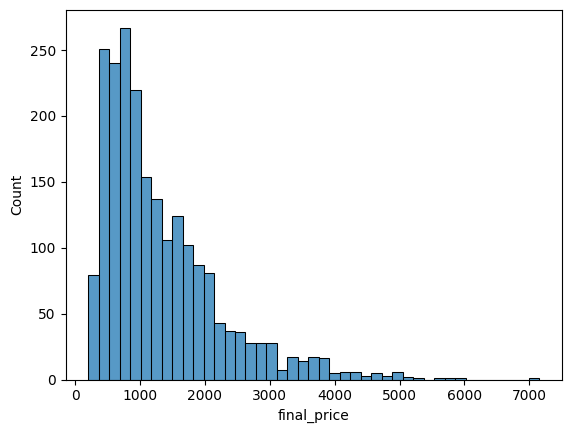

In [5]:
sns.histplot(df['final_price'])

### Question 1

There's one column with missing values. What is it?

In [6]:
na_cols = df.columns[df.isna().apply(lambda x: any(x), axis=0)].tolist()
print(len(na_cols))
na_cols

1


['screen']

In [7]:
df.isnull().sum()

ram            0
storage        0
screen         4
final_price    0
dtype: int64

### Question 2

What's the median (50% percentile) for variable 'ram'?

In [8]:
df['ram'].median()

16.0

### Preparing and splitting the dataset

Shuffling the dataset (the filtered one you created above), using seed 42.

Splitting data in train/val/test sets, with 60%/20%/20% distribution.

In [9]:
n = df.shape[0]

n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test

idx = np.arange(n)
np.random.seed(42)
np.random.shuffle(idx)

df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train:n_train+n_val]]
df_test = df.iloc[idx[n_train+n_val:]]

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

X_train = df_train[['ram', 'storage', 'screen']]
y_train = df_train['final_price']

X_val = df_val[['ram', 'storage', 'screen']]
y_val = df_val['final_price']

X_test = df_test[['ram', 'storage', 'screen']]
y_test = df_test['final_price']

len(X_train), len(X_val), len(X_test)

(1296, 432, 432)

### Question 3

We need to deal with missing values for the column from Q1.

We have two options: fill it with 0 or with the mean of this variable.

Try both options. For each, train a linear regression model without regularization using the code from the lessons. For computing the mean, use the training only! 

Use the validation dataset to evaluate the models and compare the RMSE of each option.

Round the RMSE scores to 2 decimal digits using round(score, 2)

Which option gives better RMSE?

In [10]:
def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)


def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y) 
    return w_full[0], w_full[1:]

In [11]:
# Replacing NA with mean

screen_mean = X_train['screen'].mean()
X_train_fmean = X_train.fillna(value={'screen':screen_mean}, inplace=False)
X_val_fmean = X_val.fillna(value={'screen':screen_mean}, inplace=False)

w0, w = train_linear_regression(X_train_fmean, y_train)

y_pred = w0 + X_val_fmean.dot(w)

round(rmse(y_val, y_pred),2)

600.27

In [12]:
# Replacing NA with zeroes

X_train_fzero = X_train.fillna(value={'screen':0}, inplace=False)
X_val_fzero = X_val.fillna(value={'screen':0}, inplace=False)


w0, w = train_linear_regression(X_train_fzero, y_train)

y_pred = w0 + X_val.dot(w)

round(rmse(y_val, y_pred),2)

596.96

### Question 4

Now let's train a regularized linear regression.

For this question, fill the NAs with 0.

Try different values of r from this list: [0, 0.01, 0.1, 1, 5, 10, 100].

Use RMSE to evaluate the model on the validation dataset.

Round the RMSE scores to 2 decimal digits.

Which r gives the best RMSE?

If there are multiple options, select the smallest r.

In [13]:
# Without log and standartization

def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

X_train_fzero = X_train.fillna(value={'screen':0}, inplace=False)
X_val_fzero = X_val.fillna(value={'screen':0}, inplace=False)

rmse_dict = {}
for r in [0, 0.01, 0.1, 1, 5, 10, 100]:
    w0, w = train_linear_regression_reg(X_train_fzero, y_train, r)

    y_pred = w0 + X_val_fzero.dot(w)
    rmse_dict[r] = round(rmse(y_val, y_pred),2)

rmse_dict

{0: 597.36,
 0.01: 597.36,
 0.1: 597.35,
 1: 597.21,
 5: 597.01,
 10: 597.06,
 100: 597.9}

### Question 5

We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.

Try different seed values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9].

For each seed, do the train/validation/test split with 60%/20%/20% distribution.

Fill the missing values with 0 and train a model without regularization.

For each seed, evaluate the model on the validation dataset and collect the RMSE scores.

What's the standard deviation of all the scores? To compute the standard deviation, use np.std.

Round the result to 3 decimal digits (round(std, 3))


In [14]:
rmse_list = []

for seed in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:    
    idx = np.arange(n)
    np.random.seed(seed)
    np.random.shuffle(idx)
    
    df_train = df.iloc[idx[:n_train]]
    df_val = df.iloc[idx[n_train:n_train+n_val]]
    df_test = df.iloc[idx[n_train+n_val:]]
    
    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    
    X_train = df_train[['ram', 'storage', 'screen']]
    y_train = df_train['final_price']
    
    X_val = df_val[['ram', 'storage', 'screen']]
    y_val = df_val['final_price']

    X_test = df_test[['ram', 'storage', 'screen']]
    y_test = df_test['final_price']

    X_train_fzero = X_train.fillna(value={'screen':0}, inplace=False)
    X_val_fzero = X_val.fillna(value={'screen':0}, inplace=False)
       
    w0, w = train_linear_regression(X_train_fzero, y_train)
    
    y_pred = w0 + X_val.dot(w)
    
    rmse_list.append(rmse(y_val, y_pred))
    
round(np.std(rmse_list),3)

29.226

### Question 6

Split the dataset like previously, use seed 9.

Combine train and validation datasets.

Fill the missing values with 0 and train a model with r=0.001.

What's the RMSE on the test dataset?

In [15]:
idx = np.arange(n)
np.random.seed(9)
np.random.shuffle(idx)

df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train:n_train+n_val]]
df_test = df.iloc[idx[n_train+n_val:]]

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

X_train = df_train[['ram', 'storage', 'screen']]
y_train = df_train['final_price']

X_val = df_val[['ram', 'storage', 'screen']]
y_val = df_val['final_price']

X_test = df_test[['ram', 'storage', 'screen']]
y_test = df_test['final_price']

X_concatenated = pd.concat([X_train, X_val])
y_concatenated = pd.concat([y_train, y_val])

X_concatenated_fzero = X_concatenated.fillna(value={'screen':0}, inplace=False)
X_test_fzero = X_test.fillna(value={'screen':0}, inplace=False)

w0, w = train_linear_regression_reg(X_concatenated_fzero, y_concatenated, r=0.001)

y_pred = w0 + X_test_fzero.dot(w)
round(rmse(y_test, y_pred),2)

608.61